1
2
3
4
5
6
7
8
9
max err 0.06967705488204956
mean err 0.002412150576529922
max w 0.11428748816251755
(0.0, 9.989999771118164, 0.0, 0.949999988079071)


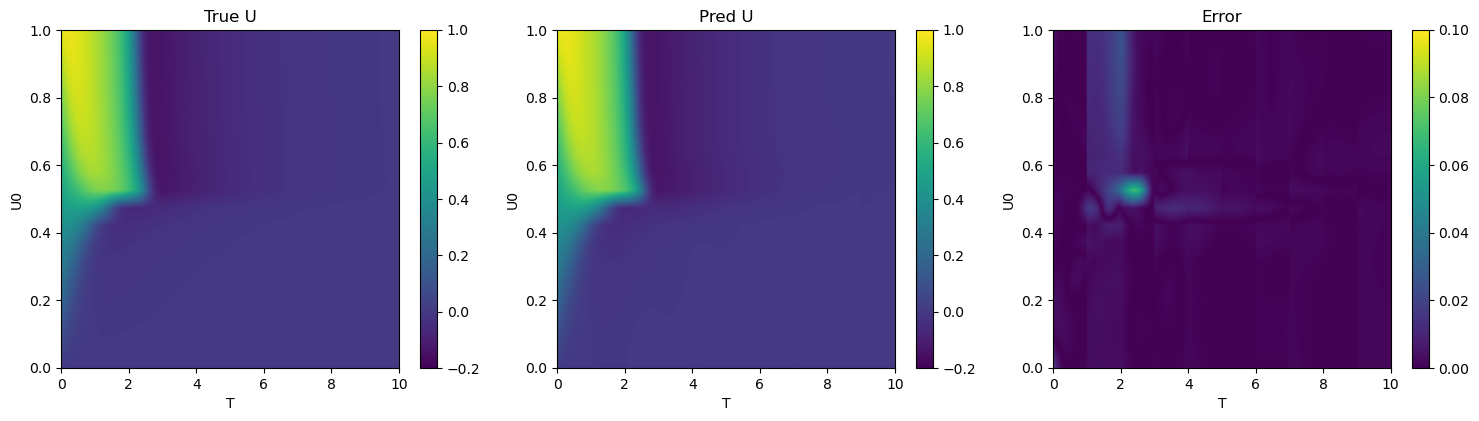

In [1]:
import numpy as np
import matplotlib.pyplot as plt

##mostra que ele cria uma cond inicial novamente para cada janela
import vtk
import matplotlib.pyplot as plt
import scipy  

import vtk
from vtk.util.numpy_support import vtk_to_numpy


def interpolate_2D( size, invar, *outvars):
        "Interpolate 2D outvar solutions onto a regular mesh"

        assert len(invar) == 2

        # define regular mesh to interpolate onto
        xs = [invar[k][:, 0] for k in invar]
        extent = (xs[0].min(), xs[0].max(), xs[1].min(), xs[1].max())
        xyi = np.meshgrid(
            np.linspace(extent[0], extent[1], size),
            np.linspace(extent[2], extent[3], size),
            indexing="ij",
        )

        # interpolate outvars onto mesh
        outvars_interp = []
        for outvar in outvars:
            outvar_interp = {}
            for k in outvar:
                outvar_interp[k] = scipy.interpolate.griddata(
                    (xs[0], xs[1]), outvar[k][:, 0], tuple(xyi)
                )
            outvars_interp.append(outvar_interp)

        return [extent] + outvars_interp

def all(invar, true_outvar, pred_outvar):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    img = ax.scatter(invar["K"], invar["V"],invar["t"],c=pred_outvar["x1"])
    
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    fig.colorbar(img)
    plt.show()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    img = ax.scatter(invar["K"], invar["V"],invar["t"],c=true_outvar["x1"])
    
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    fig.colorbar(img)
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(invar["K"], invar["V"],invar["t"],c=((true_outvar["x1"] -pred_outvar["x1"])**2)**0.5 ) 
    
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()

    fig.colorbar(img)
    plt.show()
    
def call(invar, true_outvar, pred_outvar):
        extent, true_outvar, pred_outvar = interpolate_2D(
                200, invar, true_outvar, pred_outvar
            )
        ndim=2
        print(extent)

        dims = list(invar.keys())
        fs = []
        for k in pred_outvar:
            f = plt.figure(figsize=(3 * 5, 4), dpi=100)
            for i, (o, tag) in enumerate(
                zip(
                    [true_outvar[k], pred_outvar[k], ((true_outvar[k] - pred_outvar[k])**2)**(0.5) ],
                    ["True U", "Pred U", "Error"],
                )
            ):
                if (tag=="diff"):
                    to=o
                    to[0][0]=0
                plt.subplot(1, 3, 1 + i)
                if ndim == 1:
                    plt.plot(invar[dims[0]][:, 0], o[:, 0])
                    plt.xlabel(dims[0])
                elif ndim == 2:
                    plt.imshow(o.T, origin="lower",extent=(0,10,0,1),aspect=10)
                    
                    plt.xlabel("T")
                    plt.ylabel("U0")
                
                    if(tag=="Error"):
                       
                        plt.clim(0,0.1)
                    else :
                        plt.clim(-.2,1)
                    plt.colorbar()
                plt.title(f"{tag}")
            plt.tight_layout()


def read_vtp(path):
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(path)
    reader.Update()
    data = reader.GetOutput().GetPointData()
   # print(data)
    field_count = data.GetNumberOfArrays()
    return {data.GetArrayName(i): vtk_to_numpy(data.GetArray(i)) for i in range(field_count)}

def r(path):
    
    data=read_vtp(path)
    #print(data["t"])
    return data["t"],data["pred_x1"],data["K"],data["true_x1"],data["pred_w"],data["true_w"]
def plot(path):

    data=read_vtp(path)
    #print(data)

    print(i)
   
    #print(([i]))   
    plt.scatter(data['t'],data['true_x1'],"or")

    plt.scatter(data['t'],data['pred_x1'],"b")

    plt.ylim(-1,1)

       
def find(list_to_check, item_to_find):
    return [idx for idx, value in enumerate(list_to_check) if value == item_to_find]



p=lambda s:'outputs/fhn2SIM/window'+str(s)+'/validators/validator.vtp'
#plot('NOVOS/outputs/fhn2SIM/initial_conditions/validators/validator.vtp')


t,x,k,tx,w,tw= r('outputs/fhn2SIM/initial_conditions/validators/validator.vtp')
n_w=10

n=np.shape(x)[0]
T=np.zeros(n*n_w)
X=np.zeros(n*n_w)
K=np.zeros(n*n_w)
TX=np.zeros(n*n_w)
W=np.zeros(n*n_w)
TW=np.zeros(n*n_w)

T[0:n]=t
X[0:n]=x
K[0:n]=k
TX[0:n]=tx
W[0:n]=w
TW[0:n]=tw

for i in range(1,10):
    print(i)
    d=r(p(i))
    #plot(p(i))
    
    T[n*i:n*(i+1)]=d[0]
    X[n*i:n*(i+1)]=d[1]
    K[n*i:n*(i+1)]=d[2]
    TX[n*i:n*(i+1)]=d[3]
    W[n*i:n*(i+1)]=d[4]
    TW[n*i:n*(i+1)]=d[5]
          



print("max err",np.max(   (((X-TX)**2)**0.5 ))   )
print("mean err",np.mean( (((X-TX)**2)**0.5 ))  )
print("max w",(np.max( W)))

e=lambda x:np.expand_dims(x,axis=1)

invar={"t":e(T.T )  ,"K":e(K.T)   }
out={"x1":e(X),       }
out_t={"x1":e(TX.T),         }

call(invar,out_t,out)
plt.savefig("fig1.png")

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


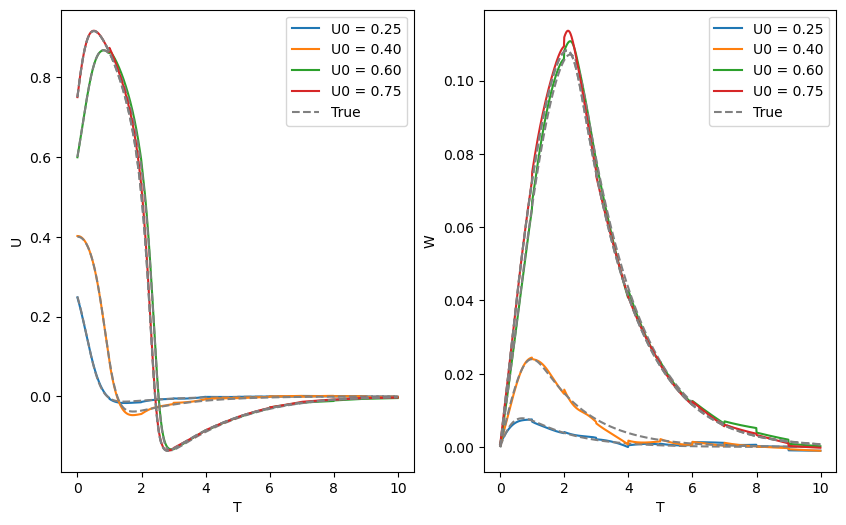

In [31]:
fig,a=plt.subplots(1, 2,sharex=False,sharey=False,figsize=(10 , 6), dpi=100)


u=np.unique(K)
us=[u[5],u[8],u[12],u[15]]

d=0
for v in (us):
  
    i=find(K,v)
    i=[a for a in i if a%1==0]
   
    invar={"t":e(T.T[i] )  ,"K":e(K.T)[i]  }

    out={"x1":e(X)[i],       }
    out_t={"x1":e(TX.T)[i],         }
    print(np.shape(i))
    a[0].plot(invar["t"],out["x1"],label="U0 = "+"{:.2f}".format(v))
    a[0].set_xlabel("T")
    a[0].set_ylabel("U")
    
    a[0].plot(invar["t"],out_t["x1"],"--",color="grey")
    d=d+1
    
a[0].plot(invar["t"],out_t["x1"],"--",color="grey",label="True")
a[0].legend(loc='best')



u=np.unique(K)
us=[u[5],u[8],u[12],u[15]]

d=0
for v in (us):
  
    i=find(K,v)
    i=[a for a in i if a%1==0]
   
    invar={"t":e(T.T[i] )  ,"K":e(K.T)[i]  }

    out={"x1":e(W)[i],       }
    out_t={"x1":e(TW.T)[i],         }
    print(np.shape(i))
    a[1].plot(invar["t"],out["x1"],label="U0 = "+"{:.2f}".format(v))
    a[1].set_xlabel("T")
    a[1].set_ylabel("W")
    
    a[1].plot(invar["t"],out_t["x1"],"--",color="grey")
    d=d+1
    
a[1].plot(invar["t"],out_t["x1"],"--",color="grey",label="True")
a[1].legend(loc='best')





plt.savefig("x1P.png")